In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from combiners import EpochsCombiner
from typing import *
import mne
import tensorflow as tf
import mneflow as mf
import matplotlib.pyplot as plt
import numpy as np
from utils.data_management import dict2str
from lfcnn_vis import plot_patterns
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions
import pickle
from utils.machine_learning import one_hot_decoder
import sklearn.metrics as sm
from utils.machine_learning.confusion import ConfusionEstimator
from cross_runs_TF_planes import CrossRunsTFScorer

def read_pkl(path: str) -> Any:
    with open(
            path,
            'rb'
        ) as file:
        content = pickle.load(
            file
        )
    return content

2022-05-17 21:07:34.996236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 21:07:34.996272: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ModuleNotFoundError: No module named 'cross_runs_TF_planes'

In [89]:
root = '../Source/Subjects'
scores = 0
case = 'lm_vs_li'
i = 0
for subj_name in os.listdir(root):
    i += 1
    
    if subj_name == 'Pse_Udo':
        continue
    
    tf_path = os.path.join(root, subj_name, 'TF_planes', 'BB1-BB8', 'RespCor')
    tf_file = os.path.join(tf_path, f'{case}.pkl')
    scorer = read_pkl(tf_file)
    print(scorer.tf_scores.mean(0).max())
    scores += scorer.tf_scores.mean(0).max()
scores/i

0.6960897477187333
0.7250858165372503
0.69343843076526
0.847382132383333
0.7089745948538733
0.7634265758358783
0.8270903123585336
0.6895991021324355


0.661231856953922

In [3]:
import pandas as pd
from utils.console.colored import warn

class PredictionsParser(object):
    def __init__(
        self,
        y_true: Union[list[int], np.ndarray],
        y_pred: Union[list[int], np.ndarray],
        class_names: Optional[Union[str, list[str]]] = None
    ):
        
        y_true = self.__check_numpy(y_true)
        y_pred = self.__check_numpy(y_pred)
        
        if y_true.shape != y_pred.shape:
            raise ValueError('Predictions and actual values are inconsistent. Actual values shape: {y_true.shape}, predictions shape: {y_pred.shape}')
        
        if len(y_true.shape) != 1:
            y_true = one_hot_decoder(y_true)
            y_pred = one_hot_decoder(y_pred)
        
        self._y_true = y_true
        self._y_pred = y_pred
        
        self._accuracy = sm.accuracy_score(y_true, y_pred)
        
        classes_true = np.unique(self._y_true)
        classes_pred = np.unique(self._y_pred)
        
        if np.any(classes_true != classes_pred):
            warn(f'Warning: Classes are inconsistent.\n\tActual classes: {classes_true}\n\tPredicted classes: {classes_pred}.\nTake actual classes')
            
        del classes_pred
        
        self._classes = classes_true
        self._n_classes = len(classes_true)
        
        if class_names is not None:
            
            if isinstance(class_names, str):
                class_names = class_names.split(' ')
            
            if len(class_names) != self.n_classes:
                raise ValueError(f'Class names and classes are inconsistent: number of classes is {self.n_classes}, but {len(class_names)} names of classes were given')
        else:
            class_names = [f'Class {i}' for i in range(self.n_classes)]
        
        self._class_names = class_names
        
        self._confusion = pd.DataFrame(
            sm.confusion_matrix(self.y_true, self.y_pred),
            index = [f'Actual {class_name}' for class_name in self.class_names],
            columns = [f'Predicted {class_name}' for class_name in self.class_names]
        )
    
    @staticmethod
    def __check_numpy(arr: Union[list, tuple, np.ndarray]):
        if isinstance(arr, np.ndarray):
            return arr
        elif not isinstance(arr, np.ndarray) and isinstance(arr, (list, tuple)):
            return np.array(arr)
        else:
            raise ValueError(f'The given argument must be either a np.ndarray or a list, but {type(arr)} was given')
        
    @property
    def y_true(self):
        return self._y_true
    @y_true.setter
    def y_true(self, value):
        raise AttributeError('Impossible to set y_true directly')
    
    @property
    def y_pred(self):
        return self._y_pred
    @y_pred.setter
    def y_pred(self, value):
        raise AttributeError('Impossible to set y_pred directly')
    
    @property
    def accuracy(self):
        return self._accuracy
    @accuracy.setter
    def accuracy(self, value):
        raise AttributeError('Impossible to set accuracy directly')
    
    @property
    def classes(self):
        return self._classes
    @classes.setter
    def classes(self, value):
        raise AttributeError('Impossible to set classes directly')
    
    @property
    def n_classes(self):
        return self._n_classes
    @n_classes.setter
    def n_classes(self, value):
        raise AttributeError('Impossible to set number of classes directly')
    
    @property
    def class_names(self):
        return self._class_names
    @class_names.setter
    def class_names(self, value):
        raise AttributeError('Impossible to set names for classes directly')
    
    @property
    def confusion(self):
        return self._confusion
    @confusion.setter
    def confusion(self, value):
        raise AttributeError('Impossible to set confusion matrix directly')
    
    def summary(self, *args: str):
        df = self.confusion.copy()
        summary = pd.DataFrame(columns = self.class_names)
        summary.loc['Total'] = [df[column].sum() for column in df.columns]
        summary.loc['Accuracy'] = [None for _ in range(self.n_classes)]
        summary.loc['Specificity'] = [None for _ in range(self.n_classes)]
        summary.loc['Sensitivity'] = [None for _ in range(self.n_classes)]
        
        ec = self.estimate_confusion()
        
        args = list(args)
        for i, arg in enumerate(args):
            if not isinstance(arg, tuple):
                args[i] = arg, arg
        
        for arg_value, arg_name in args:
            if hasattr(ec[self.class_names[0]], arg_value):
                summary.loc[arg_name] = [None for _ in range(self.n_classes)]
            else:
                warn(f'WARNING: the {arg_value} property was not found in the confusion evaluator, so it was ignored')
                args.remove((arg_value, arg_name))
            
        
        for i, class_name in enumerate(self.class_names):
            summary[class_name].loc['Accuracy'] = ec[class_name].acc
            summary[class_name].loc['Specificity'] = ec[class_name].spec
            summary[class_name].loc['Sensitivity'] = ec[class_name].sens
            
            for arg_value, arg_name in args:
                summary[class_name].loc[arg_name] = getattr(ec[class_name], arg_value)
            
        return summary
    
    def estimate_confusion(self):
        
        return {
            class_name: ConfusionEstimator(
                # tp, tn, fp, fn
                self.confusion[self.confusion.columns[i]][self.confusion.index[i]],
                self.confusion[
                    list(self.confusion.columns[:i]) + list(self.confusion.columns[i+1:])
                    ].loc[
                        list(self.confusion.index[:i]) + list(self.confusion.index[i+1:])
                ].sum().sum(),
                self.confusion[self.confusion.columns[i]].loc[
                    list(self.confusion.index[:i]) + list(self.confusion.index[i+1:])
                ].sum(),
                self.confusion[
                    list(self.confusion.columns[:i]) + list(self.confusion.columns[i+1:])
                ].loc[self.confusion.index[i]].sum()
            )
            for i, class_name in enumerate(self.class_names)
        }



In [12]:

perf_tables_path = '../Source/perf_tables/'
from utils.storage_management import check_path
postfix = 'B1-B8_LFRNN'
check_path(perf_tables_path)

for subject_name in os.listdir(f'../Source/Subjects/'):
    
    subject_perf_tables_path = os.path.join(perf_tables_path, subject_name)
    check_path(subject_perf_tables_path)

    path = f'../Source/Subjects/{subject_name}/LFRNN'

    classification_tables_path = os.path.join(subject_perf_tables_path, f'{postfix}')
    check_path(classification_tables_path)
    
    sumdf = pd.DataFrame()
    confdf = pd.DataFrame()
    for classification in [
        'RM_vs_RI_vs_LM_vs_LI',
        'RM_vs_RI',
        'LM_vs_LI',
        'RM&RI_vs_LM&LI'
    ]:
        file_name = f'{classification}_{postfix}_pred.pkl'
        class_names = classification.split('_vs_')

        try:
            predictions = read_pkl(
                os.path.join(path, 'Predictions', file_name)
            )
        except FileNotFoundError:
            warn(f'File does not exist: {os.path.join(path, "Predictions", file_name)}')
            continue
        pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
        
        sumdf = pd.concat([
                sumdf,
                pp.summary(),
                pd.DataFrame([None for _ in range(pp.summary().shape[0])], index=pp.summary().index),
            ],
            axis=1
        )
        confdf = pd.concat([
                confdf,
                pp.confusion,
                # pd.DataFrame([None for _ in range(pp.confusion.shape[0])], index=pp.confusion.index),
                pd.DataFrame(list(confdf.index), index=confdf.index),
            ],
            axis=1
        )
    sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
    confdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_confusion.xls'))
    print(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))

/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: Runtime

../Source/perf_tables/Ga_Fed_06/B1-B8_LFRNN/Ga_Fed_06_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_3260006/3332066588.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_3260006/3332066588.py:52: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will 

../Source/perf_tables/Fe_To_08/B1-B8_LFRNN/Fe_To_08_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_3260006/3332066588.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_3260006/3332066588.py:52: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will 

../Source/perf_tables/Az_Mar_05/B1-B8_LFRNN/Az_Mar_05_RM&RI_vs_LM&LI_summary.xls


/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: Runtime

../Source/perf_tables/Ku_EL_09/B1-B8_LFRNN/Ku_EL_09_RM&RI_vs_LM&LI_summary.xls


/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:302: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:302: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:30

../Source/perf_tables/Pr_An_04/B1-B8_LFRNN/Pr_An_04_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_3260006/3332066588.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_3260006/3332066588.py:52: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will 

../Source/perf_tables/Ru_Ek_07/B1-B8_LFRNN/Ru_Ek_07_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_3260006/3332066588.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_3260006/3332066588.py:52: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will 

../Source/perf_tables/Se_Tu_03/B1-B8_LFRNN/Se_Tu_03_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_3260006/3332066588.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_3260006/3332066588.py:52: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will 

../Source/perf_tables/Te_Ali_11/B1-B8_LFRNN/Te_Ali_11_RM&RI_vs_LM&LI_summary.xls
../Source/perf_tables/Pse_Udo/B1-B8_LFRNN/Pse_Udo_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_3260006/3332066588.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_3260006/3332066588.py:52: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will 

In [11]:
from utils.storage_management import check_path
perf_tables_path = '../Source/perf_tables/LFRNN'
check_path(perf_tables_path)
from utils.storage_management import check_path
postfix = 'B1-B8_LFRNN'
group_tables_path = os.path.join(perf_tables_path, 'Group')
check_path(group_tables_path)
classification_tables_path = os.path.join(group_tables_path, postfix)
check_path(perf_tables_path, group_tables_path, classification_tables_path)

sumdf = pd.DataFrame()
confdf = pd.DataFrame()
for classification in [
        'RM_vs_RI_vs_LM_vs_LI',
        'RM_vs_RI',
        'LM_vs_LI',
        'RM&RI_vs_LM&LI'
    ]:
    conf = list()
    summary = list()
    for subject_name in os.listdir(f'../Source/Subjects/'):
        path = f'../Source/Subjects/{subject_name}/LFRNN'
        check_path(path)
        
        file_name = f'{classification}_{postfix}_pred.pkl'
        class_names = classification.split('_vs_')

        try:
            predictions = read_pkl(
                os.path.join(path, 'Predictions', file_name)
            )
        except FileNotFoundError:
            warn(f'File does not exist: {os.path.join(path, "Predictions", file_name)}')
            continue
        pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
        conf.append(pp.confusion)
        summary.append(pp.summary())
    
    index, columns = summary[0].index, summary[0].columns
    data = np.array([c.to_numpy() for c in summary]).mean(0)
    local_summary = pd.DataFrame(data, index=index, columns=columns)
    sumdf = pd.concat([
        sumdf,
        local_summary,
        pd.DataFrame([None for _ in range(local_summary.shape[0])], index=local_summary.index),
    ], axis=1)
    
    index, columns = conf[0].index, conf[0].columns
    data = np.array([s.to_numpy() for s in conf]).mean(0)
    local_conf = pd.DataFrame(data, index=index, columns=columns)
    confdf = pd.concat([
        confdf,
        local_conf,
        pd.DataFrame(list(local_conf.index), index=local_conf.index),
    ], axis=1)

sumdf.to_excel(
    os.path.join(classification_tables_path, f'group_{classification}_summary.xls')
)
confdf.to_excel(os.path.join(classification_tables_path, f'group_{classification}_confusion.xls'))

/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:300: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:302: Runtime

In [4]:
subject_name = 'Ga_Fed_06'

path = f'../Source/Subjects/{subject_name}/LFRNN'

# file_name = 'LM&LI_vs_RM&RI_B1-B8_pred.pkl'
# file_name = 'LM_vs_LI_vs_RM_vs_RI_B1-B8_pred.pkl'
file_name = 'LM_vs_LI_B1-B8_pred.pkl'
class_names = file_name[:-15].split('_vs_')


predictions = read_pkl(
    os.path.join(path, 'Predictions', file_name)
)
print(predictions.y_true.shape)
pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
print(pp.accuracy)
print(pp.confusion)
pp.summary()

(75, 2)
0.8266666666666667
           Predicted LM  Predicted LI
Actual LM            28             6
Actual LI             7            34


,LM,LI
Total,35,40
Accuracy,0.826667,0.826667
Specificity,0.829268,0.823529
Sensitivity,0.823529,0.829268


In [193]:



subjects_path = '../Source/Subjects/'
file_name = 'LM_vs_LI_vs_RM_vs_RI_B1-B8_pred.pkl'
# file_name = 'LM&LI_vs_RM&RI_B1-B8_pred.pkl'
class_names = file_name[:-15].split('_vs_')

for subject_name in os.listdir(subjects_path):
    
    if subject_name == 'Pse_Udo':
        continue
    
    subject_path = os.path.join(subjects_path, subject_name)

    predictions = read_pkl(
        os.path.join(subject_path, 'Predictions', file_name)
    )

    pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
    print(subject_name)
    print(f'Total accuracy: {pp.accuracy : .2f}')
    summary = pp.summary()
    summary = summary.astype(float).round(2)
    print(summary)
    print(pp.confusion)
    print('-'*100)

Ga_Fed_06
Total accuracy:  0.55
                LM     LI     RM    RI
Total        16.00  12.00  16.00  9.00
Accuracy      0.77   0.77   0.77  0.77
Specificity   0.84   0.89   0.80  0.86
Sensitivity   0.62   0.50   0.67  0.33
           Predicted LM  Predicted LI  Predicted RM  Predicted RI
Actual LM            10             4             1             1
Actual LI             6             8             1             1
Actual RM             0             0             8             4
Actual RI             0             0             6             3
----------------------------------------------------------------------------------------------------
Fe_To_08
Total accuracy:  0.57
                LM     LI     RM    RI
Total        12.00  18.00  16.00  8.00
Accuracy      0.78   0.76   0.80  0.81
Specificity   0.92   0.78   0.81  0.93
Sensitivity   0.50   0.69   0.73  0.42
           Predicted LM  Predicted LI  Predicted RM  Predicted RI
Actual LM             9             7             

/tmp/ipykernel_19962/2523103007.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.any(classes_true != classes_pred):
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:255: RuntimeWarning: invalid value encountered in long_scalars
  self._ppv = self.tp / (self.tp + self.fp)
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:263: RuntimeWarning: invalid value encountered in true_divide
  self._mcc = (self.tp * self.tn - self.fp * self.fn) / \


In [192]:
pp.confusion

,Predicted LM,Predicted LI,Predicted RM,Predicted RI
Actual LM,6,4,3,1
Actual LI,3,2,2,3
Actual RM,0,2,10,1
Actual RI,3,0,7,6


In [196]:
subjects_path = '../Source/Subjects/'
# file_name = 'LM_vs_LI_vs_RM_vs_RI_B1-B8_pred.pkl'
# file_name = 'LM&LI_vs_RM&RI_B1-B8_pred.pkl'
file_name = 'LM_vs_LI_B1-B8_pred.pkl'
class_names = file_name[:-15].split('_vs_')

for subject_name in os.listdir(subjects_path):
    
    if subject_name == 'Pse_Udo':
        continue
    
    subject_path = os.path.join(subjects_path, subject_name)

    predictions = read_pkl(
        os.path.join(subject_path, 'Predictions', file_name),
    )

    y_t = one_hot_decoder(predictions.y_true)

    y_p = one_hot_decoder(predictions.y_p)

    print(subject_name)
    tn, fp, fn, tp = sm.confusion_matrix(y_t, y_p).ravel()
    ce = ConfusionEstimator(tp, tn, fp, fn)

    print(
        f'\tT\tF\n'\
        f'P\t{tp}\t{fp}\n'\
        f'N\t{tn}\t{fn}\n'
        f'Accuracy: {ce.acc}\n'\
        f'Specificity: {ce.spec}\n'\
        f'Sensitivity: {ce.sens}\n'
    )

Ga_Fed_06


ValueError: not enough values to unpack (expected 4, got 1)

In [2]:
def draw_sp(iy, waveforms, temporal_parameters, spatial_parameters, logscale=False):
        data = spatial_parameters.patterns.copy()
        # fig2, axs = plt.subplots(3)
        # ax21, ax22, ax23 = axs
        fig2 = plt.figure(constrained_layout=False)
        gs2 = fig2.add_gridspec(
            nrows=9,
            ncols=3,
            bottom=.1,
            wspace=.05,
            hspace=.1
        )
        ax21 = fig2.add_subplot(gs2[:3, :])
        ax22 = fig2.add_subplot(gs2[3:6, 1:2])
        ax23 = fig2.add_subplot(gs2[6:, 1:2])
        plot_patterns(data, info, iy, ax21, name_format='', title='')
        ax22_t = ax22.twinx()
        ax22_t.plot(sp.stats.zscore(waveforms.evoked[iy]), '#454545')
        pos = ax22.imshow(np.flip(waveforms.induced[iy, :, :], axis=0), cmap='RdBu_r')
        cb = fig2.colorbar(pos, ax=ax22, pad=0.2, orientation='horizontal', aspect=75, fraction=.12)
        ax22.set_aspect('auto')
        ax22_t.set_aspect('auto')
        # ax22_t.set_ylim(top=1, bottom=-1)
        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.finputs[iy]),
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.foutputs[iy]),
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.fresponces[iy]),
                        )
        ax22_t.set_ylabel('Amplitude (μV)', labelpad=12.5, rotation=270)
        ax22_t.spines['top'].set_alpha(.2)
        ax22_t.spines['right'].set_alpha(.2)
        ax22_t.spines['left'].set_alpha(.2)
        ax22_t.spines['bottom'].set_alpha(.2)
        ax22_t.tick_params(axis='both', which='both',length=5, color='#00000050')
        ax22.spines['top'].set_alpha(.2)
        ax22.spines['right'].set_alpha(.2)
        ax22.spines['left'].set_alpha(.2)
        ax22.spines['bottom'].set_alpha(.2)
        ax22.tick_params(axis='both', which='both',length=5, color='#00000050')
        cb.outline.set_color('#00000020')
        cb.ax.tick_params(axis='both', which='both',length=5, color='#00000050')
        times = np.unique(np.round(waveforms.times, 1))
        ranges = np.linspace(0, len(waveforms.times), len(times)).astype(int)
        ax22.set_xticks(ranges)
        ax22.set_xticklabels(times)
        freqs = [0] + [(i+1) for i in range(waveforms.induced.shape[-2]) if (i+1)%10==0]
        ax22.set_yticks(freqs)
        ax22.set_yticklabels(sorted(freqs, reverse=True))
        ax22.set_xlabel('Time (s)')
        ax22.set_ylabel('Frequency (Hz)')
        ax23.legend(['Filter input', 'Filter output', 'Filter responce'], loc='upper right')      
        ax23.spines['top'].set_alpha(.2)
        ax23.spines['right'].set_alpha(.2)
        ax23.spines['left'].set_alpha(.2)
        ax23.spines['bottom'].set_alpha(.2)
        ax23.tick_params(axis='both', which='both',length=5, color='#00000050')
        ax23.set_xlabel('Frequency (Hz)')
        ax23.set_ylabel('Amplitude (μV)')
        # ax23.set_ylim(top=1.2)
        
        if logscale:
            # ax23.set_aspect(25)  
            ax23.set_yscale('log')
        # else:
        #     ax23.set_aspect(75)  
            
        fig2.suptitle(f'Latent source {iy + 1}')
        plt.show()


In [103]:
%matplotlib qt
subject_name = 'Te_Ali_11'
from lfcnn_vis import *
from collections import Counter
cases_to_combine = ['RM', 'RI', 'LM', 'LI']
option = 2
option = {1: 'B1-B2', 2: 'B7-B8'}[option]

classification_name,\
    classification_postfix,\
    classification_prefix = None, f'train_{option}_test_B1-B2', ''
cases_to_combine = [case.split(' ') for case in cases_to_combine]

cases_to_combine = sorted(cases_to_combine, reverse=True)
class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

if classification_name is None:
    classification_name = '_vs_'.join(class_names)

model = f'LFCNN_train_{option}_test_B1-B2'
subjects_dir = os.path.join('../', 'Source', 'Subjects')
classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))
subject_info_path = os.path.join(subjects_dir, subject_name, 'Info')
subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
spatial_parameters = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
temporal_parameters = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_temporal.pkl'))
waveforms = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
orders = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_sorting.pkl'))
all_orders = dict(sorted(Counter(np.matrix.flatten(np.squeeze([orders[order_name] for order_name in range(len(orders))]))).items(), key=lambda x: x[1], reverse=True))
all_orders

{10: 7, 16: 2, 7: 2, 13: 2, 25: 2, 19: 1, 3: 1, 5: 1, 8: 1, 29: 1}

## Log
#### Components indices are written in brackets

* Az_Mar_05, B7-B8, The most frequent components (29, 17) has small sum of weights and noisy patterns, so components with the highest sum pf weights (30, 12) have been chosen.
* Fe_To_08, B7-B8, The most frequent component is (7), but (13, 17) has been chosen, as they have bigger sum of weights.
* Ku_EL_09, B1-B2, One of the most frequent components (27) has very low sum of weights
* Ku_EL_09, B7-B8, One of the most frequent components (19) has very low sum of weights, as well as one less frequent component (15)
* Pr_An_04, B1-B2, The most frequent components (25, 28, 0, 9) have low sum of weights
* Ru_Ek_07, B7-B8, The most frequent component (7) has low sum of weights
* Se_Tu_03, B1-B2, The most frequent component (25) has low sum of weights
* Se_Tu_03, B7-B8, The most frequent component (25) has low sum of weights
* Te_Ali_11, B1-B2, The most frequent components (24, 22) have low sum of weights

In [105]:
info = read_pkl(os.path.join(subject_info_path, os.listdir(subject_info_path)[0]))
info.pick_channels(
    list(
        filter(
            lambda ch_name: (ch_name[-1] == '2' or ch_name[-1] == '3') and 'meg' in ch_name.lower(),
            info['ch_names']
        )
    )
)

draw_sp(16, waveforms, temporal_parameters, spatial_parameters)

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = '/home/user/Downloads/perf_tables/LM_vs_LI_train_B1-B3_test_B1-B3_sep.csv'
df = pd.read_csv(path, index_col = 0)
subjects = set(df.index)
plane = np.array([i for i in range(len(subjects)*4) if not (i)%4])
data = np.array([df.test_acc[f'{subject}'].to_numpy() for subject in subjects])

(9, 12)

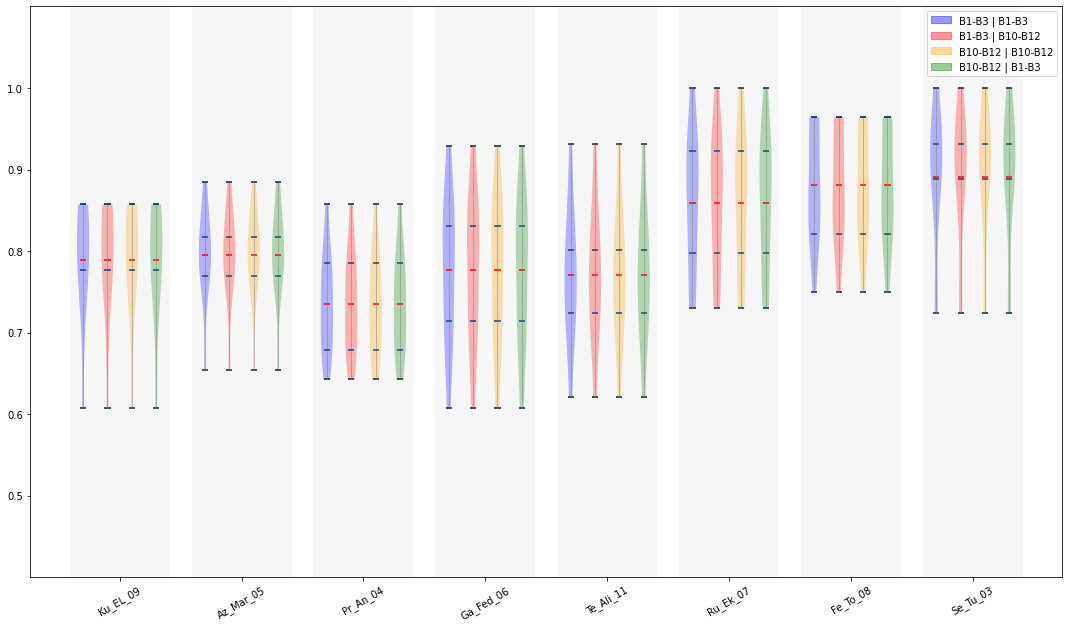

In [55]:
import matplotlib.patches as mpatches

def adjust_fig(fig):
    fig['cmeans'].set_edgecolor('r')
    fig['cmaxes'].set_edgecolor('#082032')
    fig['cmins'].set_edgecolor('#082032')
    fig['cbars'].set_edgecolor('gray')
    fig['cbars'].set_linewidth(.5)
    fig['cquantiles'].set_edgecolor('#134a74')

span = 1

plt.ylim((0.4, 1.1))
plt.yticks(
    [.5, .6, .7, .8, .9, 1.],
)
plt.grid(True, axis='x', linewidth=100, alpha=.1)

path = '/home/user/Downloads/perf_tables/LM_vs_LI_train_B1-B3_test_B1-B3_sep.csv'
df = pd.read_csv(path, index_col = 0)
subjects = set(list(df.index) + ['Average'])
plane = np.array([i for i in range(len(subjects)*4) if not (i)%4])
data = np.array([df.test_acc[f'{subject}'].to_numpy() for subject in subjects])

fig = plt.violinplot(
    data.T, plane + np.array(range(len(plane)))*span,
    showmeans=True,
    quantiles = [[0.25, 0.75] for _ in subjects]
)
for i in range(len(subjects)):
    fig['bodies'][i].set_facecolor('b')
adjust_fig(fig)

fig = plt.violinplot(
    data.T, plane + 1 + np.array(range(len(plane)))*span,
    showmeans=True,
    quantiles = [[0.25, 0.75] for _ in subjects]
)
for i in range(len(subjects)):
    fig['bodies'][i].set_facecolor('r')
adjust_fig(fig)

fig = plt.violinplot(
    data.T, plane + 2 + np.array(range(len(plane)))*span,
    showmeans=True,
    quantiles = [[0.25, 0.75] for _ in subjects]
)
for i in range(len(subjects)):
    fig['bodies'][i].set_facecolor('orange')
adjust_fig(fig)

fig = plt.violinplot(
    data.T, plane + 3 + np.array(range(len(plane)))*span,
    showmeans=True,
    quantiles = [[0.25, 0.75] for _ in subjects]
)
for i in range(len(subjects)):
    fig['bodies'][i].set_facecolor('g')
adjust_fig(fig)

_ = plt.xticks(
    plane + 1.5 + np.array(range(len(plane)))*span,
    subjects,
    rotation=30
)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
b = mpatches.Patch(color='blue', label='B1-B3 | B1-B3', alpha=.4)
r = mpatches.Patch(color='red', label='B1-B3 | B10-B12', alpha=.4)
o = mpatches.Patch(color='orange', label='B10-B12 | B10-B12', alpha=.4)
g = mpatches.Patch(color='green', label='B10-B12 | B1-B3', alpha=.4)
plt.legend(handles=[b, r, o, g])


In [177]:
plt.rcParams.update({'font.size': 22})

In [191]:
import itertools as it
span = 1

for classification, title in zip(
    [
        'RM_vs_RI_vs_LM_vs_LI',
        'RM&RI_vs_LM&LI',
        'LM_vs_LI',
        'RM_vs_RI'
    ], [
        '4 classes',
        'Left vs Right',
        'Within Left',
        'Within Right'
    ]
):
    plt.ylim((0.4, 1.25))
    plt.yticks(
        [.5, .6, .7, .8, .9, 1.],
    )
    plt.grid(True, axis='x', linewidth=100, alpha=.1)

    order = list(it.product(['B1-B3', 'B10-B12'], repeat=2))
    order[-1], order[-2] = order[-2], order[-1]
    for i, ((seq1, seq2), color) in enumerate(zip(order, ['blue', 'red', 'orange', 'green'])):
        path = f'/home/user/Downloads/perf_tables/{classification}_train_{seq1}_test_{seq2}_sep.csv'
        df = pd.read_csv(path, index_col = 0)
        subjects = set(df.index)
        data = np.array([df.test_acc[f'{subject}'].to_numpy() for subject in subjects])
        data = np.append(data, [data.mean(0)], axis = 0)
        subjects = list(subjects) + ['Average']
        plane = np.array([i for i in range(len(subjects)*4) if not (i)%4])
        fig = plt.violinplot(
            data.T, plane + i + np.array(range(len(plane)))*span,
            showmeans=True,
            quantiles = [[0.25, 0.75] for _ in subjects]
        )
        for i in range(len(subjects)):
            fig['bodies'][i].set_facecolor(color)
        adjust_fig(fig)

    _ = plt.xticks(
        plane + 1.5 + np.array(range(len(plane)))*span,
        subjects,
        rotation=30
    )

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    b = mpatches.Patch(color='blue', label='B1-B3 | B1-B3', alpha=.4)
    r = mpatches.Patch(color='red', label='B1-B3 | B10-B12', alpha=.4)
    o = mpatches.Patch(color='orange', label='B10-B12 | B10-B12', alpha=.4)
    g = mpatches.Patch(color='green', label='B10-B12 | B1-B3', alpha=.4)
    plt.legend(handles=[b, r, o, g])
    # plt.title(title)
    # plt.show()
    plt.savefig(f'/home/user/Downloads/Pics/{classification}.png')
    plt.close()
